## Семинар 1 "Полносвязные нейронные сети"

ФИО: Смирнов Михаил Андреевич

В этом задании вам предстоит реализовать проход "вперед" для полносвязной нейронную сети. В дальнейшем мы реализуем процедуру обучения и научим сеть распознавать рукописные цифры.

На первой лекции мы познакомились с тем, что такое нейронные сети и изучили три слоя — линейный, сигмоида и SoftMax. Из этих слоев можно составлять глубокие архитектуры и обучать их при помощи градиентного спуска. Чтобы конструировать сложные архитектуры, можно реализовать каждый тип слоя как отдельный "кирпичик" и затем собирать полную архитектуру как конструктор. Это мы и попробуем сделать на первом и втором семинарах.

Каждый тип слоя мы будем реализовывать при помощи класса, который будет поддерживать три функции: forward, которая будет применять функцию, реализуемую слоем, к входной матрице и backward, которая будет вычислять градиенты и step, которая будет обновлять веса. Чтобы не применять функцию к каждому объекту в отдельности, мы будем подавать на вход слою матрицу размера (N, d), где N — количество объектов, а d — размерность каждого объекта.

<img src=backprop.pdf width=400/>

Функция forward будет вычислять по $x$ значение $y$, backward — по $\frac{\partial L}{\partial y}$ вычислять $\frac{\partial L}{\partial x}$ и обновлять внутри себя $\frac{\partial L}{\partial w}$.

Важным требованием к реализации является векторизация всех слоев: все операции должны быть сведены к матричным, не должно быть циклов. Это значительно уменьшает временные затраты.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

### Часть 1: Линейный слой


Приведем пример вычисления градиентов для линейного слоя: $y = Wx$, $x \in \mathbb{R}^{K \times n}$, $y \in \mathbb{R}^{K \times n}$, $W \in \mathbb{R}^{n \times m}$, где $K$ — число объектов.

Рассмотрим $L$ как функцию от выходов нейронной сети: $L = L(y_{11}, y_{12}, \dots)$

$$y_{kt} = (Wx)_{kt} = \sum_{z=1}^{n} x_{kz}W_{zt}$$

$$\frac{\partial L}{\partial x_{ij}} = \sum_{kt} \frac{\partial L}{\partial y_{kt}}\frac{\partial y_{kt}}{\partial x_{ij}} = \sum_{kt} \frac{\partial L}{\partial y_{kt}}\frac{\partial \sum_z x_{kz}w_{zt}}{\partial x_{ij}}= \sum_{t} \frac{\partial L}{\partial y_{it}}\frac{\partial w_{jt}}{\partial x_{ij}}$$

$$\frac{\partial{L}}{\partial x} = \frac{\partial{L}}{\partial y}W^T$$

In [2]:
class Linear:
    def __init__(self, input_size, output_size):
        '''
        Creates weights and biases for linear layer.
        Dimention of inputs is *input_size*, of output: *output_size*.
        '''
        self.W = np.random.randn(input_size, output_size) * 0.1
        self.b = np.zeros(output_size)
        #### YOUR CODE HERE
        #### Create weights, initialize them with samples from N(0, 0.1).
        pass
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, input_size).
        Returns output of size (N, output_size).
        Hint: You may need to store X for backward pass
        '''
        self.X = X
        self.Y = np.apply_along_axis(lambda x: x+self.b, 1, X @ self.W)

        return self.Y
    
    def backward(self, dLdy):
        '''
        1. Compute dLdw and dLdx.
        2. Store dLdw for step() call
        3. Return dLdx
        '''
        self.dLdW = (dLdy.T @ self.X).T
        self.dLdb = np.mean(dLdy, axis=0)
        self.dLdX = dLdy @ self.W.T
        
        return self.dLdX
    
    def step(self, learning_rate):
        '''
        1. Apply gradient dLdw to network:
        w <- w - l*dLdw
        '''
        self.W = self.W - learning_rate*self.dLdW
        self.b = self.b - learning_rate*self.dLdb
        
        pass

### Часть 2: Численный градиент

Релизуйте функцию проверки численного градиента. Для этого для каждой переменной, по которой считается градиент, надо вычислить численный градиент: $f'(x) \approx \frac{f(x+\epsilon)-f(x-\epsilon)}{2\epsilon}$. Функция должна возвращать максимальное абсолютное отклонение аналитического градиента от численного. В качестве $\epsilon$ рекомендуется взять $10^{-6}$. При правильной реализации максимальное отличие будет иметь порядок $10^{-8}-10^{-6}$.

In [3]:
def check_gradient(func, X, gradient):
    '''
    Computes numerical gradient and compares it with analytcal.
    func: callable, function of which gradient we are interested. Example call: func(X)
    X: np.array of size (n x m)
    gradient: np.array of size (n x m)
    Returns: maximum absolute diviation between numerical gradient and analytical.
    '''
    eps = 10**(-6)
    
    calc = lambda x: (func(x + eps) - func(x - eps))/(2*eps)
    calc_grad = np.zeros(X.shape)

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):

            X[i, j] += eps
            f_r = func(X)
        
            X[i, j] -= 2*eps            
            f_l = func(X)   
            
            X[i, j] += eps
            calc_grad[i, j] = (f_r - f_l) / (2*eps)

    return np.max(np.abs(calc_grad - gradient))

In [4]:
# def check_gradient(func, X, gradient):
#     eps = 10**(-5)
    
#     f_grad = np.zeros(gradient.shape)
    
#     for i in range(X.shape[0]):
#         for j in range(X.shape[1]):
#             X[i, j] += eps            
#             f_r = func(X)
#             X[i, j] -= 2*eps            
#             f_l = func(X)            
#             X[i, j] += eps
                    
#             f_grad[i, j] = (f_r - f_l) / 2 / eps
    
#     return np.max(np.abs(gradient - f_grad))

Протестируйте линейный слой при помощи реализованной функции check_gradient: $\frac{\partial L}{\partial x}$ и $\frac{\partial L}{\partial w}$.

In [5]:
layer = Linear(2, 3)

X = np.random.rand(4, 2)
Y = np.random.rand(4, 3)

# X = np.array([[0, 1], [1, 1]])
# Y = np.array([[0], [1]])

# l = Linear(2, 1)
# print(layer.backward(np.ones((4, 3))))

def loss_function(W):
    layer.W = W
    res = layer.forward(X)
    return ((res - Y)**2).sum()

def loss_function_x(X):
    res = layer.forward(X)
    return ((res - Y)**2).sum()

res = layer.forward(X)
dLdy = 2 * (res - Y)
# x_check = lambda x: x @ layer.W + layer.b
# x_check = lambda x: (x**2).sum() 
# w_check = lambda W: layer.x @ W + layer.b
# b_check = lambda b: layer.x @ layer.W + b

layer.backward(dLdy)

print(check_gradient(loss_function, layer.W, layer.dLdW))
print(check_gradient(loss_function_x, X, layer.dLdX))
#print(layer.dLd)

3.778013457633733e-10
5.07784356229557e-10


### Часть 3: Сигмоида

In [6]:
class Sigmoid:
    def __init__(self):
        pass
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        self.Y = 1/(1 + np.exp(-X))
        return self.Y
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        s = self.forward(self.X)
        self.dLdX = dLdy * s * (1 - s)
#         print("s=",s, "\ndLdX = ", self.dLdX)
        return self.dLdX
    
    def step(self, learning_rate):
        pass

Протестируйте слой при помощи реализованной функции check_gradient: $\frac{\partial L}{\partial x}$.

In [7]:
sig = Sigmoid()

X = np.random.rand(2, 3)
Y = np.random.rand(2, 3)
# print(X, Y)
# X = np.array([[0, 1], [1, 1]])
# Y = np.array([[1, 1.5], [1.5, 1.5]])
# X = np.zeros((1,1))
# Y = np.ones((1,1))
def loss_function_s(X):

    res = sig.forward(X)
    
    return ((res - Y)**2).sum()

res = sig.forward(X)
dLdy = 2 * (res - Y)

sig.backward(dLdy)

print(check_gradient(loss_function_s, X, sig.dLdX))

3.216149568885385e-11


### Часть 4: Функция потерь

Как мы увидели на семинаре, вычисление производной для связки SoftMax + Negative log-likelihood проще чем для этих двух слоев по отдельности. Поэтому мы реализуем их как один класс. Важное замечание: на проходе "вперед" важно воспользоваться трюком <a href="https://blog.feedly.com/tricks-of-the-trade-logsumexp/">log-sum-exp</a>, чтобы не столкнуться с численными неустойчивостями.

In [8]:
class NLLLoss:
    def __init__(self):
        '''
        Applies Softmax operation to inputs and computes NLL loss
        '''
        #### YOUR CODE HERE
        #### (Hint: No code is expected here, just joking) :))))
        pass
    
    def forward(self, X, y):
        '''
        Passes objects through this layer.
        X is np.array of size (N, C), where C is the number of classes
        y is np.array of size (N), contains correct labels
        '''
        self.X = X
        self.y = y
        
        c = np.max(X, axis=1)[:, np.newaxis]
        
        self.log_sum_exp = X - np.log(np.sum(np.exp(X - c), axis=1))[:, np.newaxis] - c
        self.exp = np.exp(self.log_sum_exp)
        
        loss = np.apply_along_axis(lambda x: -x[int(x[-1])], 1, np.hstack((self.log_sum_exp, self.y[:,np.newaxis])))

        return loss.sum()
    
    def help_func1(self, x):
        y = np.arange(x.shape[0]-1)
        z = np.hstack((x[:-1, np.newaxis], y[:, np.newaxis]))
        x = np.apply_along_axis(lambda z: np.exp(z[0]) - 1 if z[1] == x[-1] else np.exp(z[0]), 1, z)
        
        return x
    
    def backward(self):
        '''
        Note that here dLdy = 1 since L = y
        1. Compute dLdx
        2. Return dLdx
        '''
        
        self.dLdx = np.apply_along_axis(lambda x: self.help_func1(x), 1, np.hstack((self.log_sum_exp, self.y[:, np.newaxis])))
        
        return self.dLdx

Протестируйте слой при помощи реализованной функции check_gradient: $\frac{\partial L}{\partial x}$.

In [9]:
softm = NLLLoss()

X = np.random.rand(2, 3)
y = np.around(np.random.rand(2)*3 )

def loss_f(X):
    res = softm.forward(X, y)
    return res

res = softm.forward(X, y)
softm.backward()

print(check_gradient(loss_f, X, softm.dLdx))

2.3651425262727344e-10


### Часть 5, нейронная сеть

Теперь, когда у нас есть "кирпичики", мы можем написать класс, который будет собирать всю сеть вместе 

In [10]:
class NeuralNetwork:
    def __init__(self, modules):
        '''
        Constructs network with *modules* as its layers
        '''
        self.layers = modules
 
    
    def forward(self, X):

        for layer in self.layers:
            X_out = layer.forward(X)
            X = X_out
            
        self.Y = X 
        return self.Y
    
    
    def backward(self, dLdy):
        '''
        dLdy here is a gradient from loss function
        '''
        self.layers.reverse()
        for layer in self.layers:
            dLdy = layer.backward(dLdy)
        self.layers.reverse()

            
    def step(self, learning_rate):
        
        for layer in self.layers:
            layer.step(learning_rate)

### Часть 6, обучение на простых данных

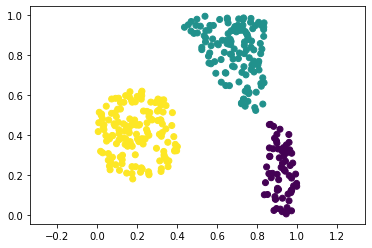

In [61]:
data = np.load('data.npz')
X, y = data['arr_0'], data['arr_1']
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.axis('equal')
plt.show()

Обучите архитектуру вида 2 -> 10 -> 10 -> 3:
* Linear(2, 10)
* Sigmoid()
* Linear(10, 10)
* Sigmoid()
* Linear(10, 3)

В качестве функции потерь используйте NLLLoss.
1. Создайте сеть, в цикле запускайте forward, backward, step (используйте learning rate 0.005). 
2. Нарисуйте график сходимости (величина NLL после каждого обновления).
3. Нарисуйте разделяющую поверхность
4. Попробуйте подобрать темп обучения. Как меняется сходимость?

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [66]:
def alpha_choise(X_train, y_train):

    a = [0.05, 0.01, 0.005, 0.004, 0.003, 0.002, 0.001, 0.0001]
    losses = []

    for alpha in a:

        print("\n----------------------alpha = ", alpha, "----------------------\n")
        fc1 = Linear(2, 10)
        sig1 = Sigmoid()
        fc2 = Linear(10, 10)
        sig2 = Sigmoid()
        fc3 = Linear(10, 3)

        modules = [fc1, sig1, fc2, sig2, fc3]

        nn = NeuralNetwork(modules)
        nll = NLLLoss()
        learning_rate = alpha
        losses_alpha = []

        for i in range(1001):

            y_pred = nn.forward(X_train)

            loss = nll.forward(y_pred, y_train)
            losses_alpha.append(loss)
            if i % 200 == 0:
                print(i, loss)

            dLdy = nll.backward()
        #     print(dLdy)
            nn.backward(dLdy)
            nn.step(learning_rate)
        losses.append((alpha, losses_alpha))
        
    return losses

In [159]:
def nn_learning(X_train, y_train, loss_class=NLLLoss, alpha=0.005):
    
    fc1 = Linear(2, 10)
    sig1 = Sigmoid()
    fc2 = Linear(10, 10)
    sig2 = Sigmoid()
    
    if loss_class == NLLLoss:
        fc3 = Linear(10, 3)
    else:
        fc3 = Linear(10, 1)

    modules = [fc1, sig1, fc2, sig2, fc3]

    nn = NeuralNetwork(modules)
    nll = loss_class()
    learning_rate = alpha

    for i in range(1001):

        y_pred = nn.forward(X_train)
        loss = nll.forward(y_pred, y_train)
        
        if i % 200 == 0:
            print(i, loss)

        dLdy = nll.backward()
        nn.backward(dLdy)
        nn.step(learning_rate)
        
    return nn

In [68]:
nn = nn_learning(X_train, y_train)
y_pred = nn.forward(X_test)

result = np.argmax(y_pred, axis=1)

0 292.5414438223199
200 215.85920327618334
400 39.01553780914911
600 8.188445337633667
800 3.65271042767919
1000 2.287274802044271


In [69]:
print(result, y_test)
accuracy_score(result, y_test)

[0 2 2 1 1 1 1 2 2 2 1 1 1 0 1 1 0 2 1 1 1 1 1 1 2 1 0 2 1 2 1 1 1 2 1 2 1
 0 1 2 1 2 2 2 1 0 1 2 1 2 2 1 2 0 1 0 1 0 1 1 2 0 2 0 1 1 1 1 0 1 2 2 2 2
 1 2 1 1 2 0 1 1 1 2 2 1 1] [0 2 2 1 1 1 1 2 2 2 1 1 1 0 1 1 0 2 1 1 1 1 1 1 2 1 0 2 1 2 1 1 1 2 1 2 1
 0 1 2 1 2 2 2 1 0 1 2 1 2 2 1 2 0 1 0 1 0 1 1 2 0 2 0 1 1 1 1 0 1 2 2 2 2
 1 2 1 1 2 0 1 1 1 2 2 1 1]


1.0

Отличная визуализация: http://playground.tensorflow.org/

## Домашнее задание:

* Подоберите темп обучения. Как меняется сходимость? Нарисуйте график оптимального значения функции потерь для различных значений learning_rate
* Решите поставленную выше задачу как задачу регрессии с MSE. Изменилась ли разделяющая поверхность?

In [15]:
import matplotlib.pyplot as plt

In [71]:
losses = alpha_choise(X_train, y_train)


----------------------alpha =  0.05 ----------------------

0 278.41387316868474
200 272.29162372994693
400 24.64644592451035
600 10.836432945541095
800 6.86492427928304
1000 5.003033934419749

----------------------alpha =  0.01 ----------------------

0 280.14365354524705
200 79.72890449035825
400 6.925488709402966
600 2.196466330380356
800 1.2582367071795222
1000 0.8716751725452192

----------------------alpha =  0.005 ----------------------

0 295.3930031255219
200 247.76817641621398
400 26.851610985560093
600 4.9653048295764535
800 2.58441984318722
1000 1.7373629756023825

----------------------alpha =  0.004 ----------------------

0 285.2757260398404
200 271.12538570485367
400 94.36980616440458
600 38.743251799225945
800 13.071140420425312
1000 5.728306215528088

----------------------alpha =  0.003 ----------------------

0 277.19416225512975
200 272.5366787744233
400 262.23926643442013
600 80.84857560551244
800 20.848051261725985
1000 8.049742875887581

----------------------

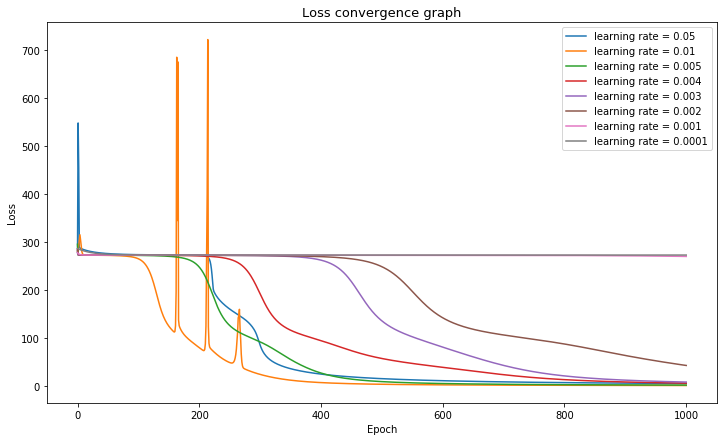

In [72]:
plt.figure(figsize=(12, 7))

for i in losses:
    plt.plot(i[1], label='learning rate = {}'.format(i[0]))
    
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Loss convergence graph', fontsize = 13)
plt.legend();

In [157]:
class MSELoss:
    
    def __init__(self):
        pass
    
    def forward(self, y_pred, y):

        self.y_pred = y_pred.reshape(y.shape[0], 1)
        self.y = y.reshape(y.shape[0], 1)
        
        return np.sum((self.y - self.y_pred)**2)
    
    def backward(self):

        return 2*(self.y_pred - self.y)

In [158]:
def nn_surface(nn, loss="mse"):
    
    min_val = np.min(X, axis=0)
    max_val = np.max(X, axis=0)
    
    step = 0.001
    
    x_grid, y_grid = np.meshgrid(np.arange(min_val[0]-0.1, max_val[0]+0.1, step), np.arange(min_val[1]-0.1, max_val[1]+0.1, step))
    
    points = np.c_[x_grid.flatten(), y_grid.flatten()]
    
    if loss == "nll":
        y_pred = np.argmax(nn.forward(points),axis=1).reshape(x_grid.shape)
        
    elif loss == "mse":
        res = nn.forward(points)
        res0 = np.zeros(res.shape)
        res1 = np.where(res > 1.5, 2, res0)
        res2 = np.where(res <= 1.5, 1, res0)
        res3 = np.where(res <= 0.5, 0, res2)
        y_pred = (res1 + res3).reshape(x_grid.shape)
    
    plt.figure(figsize = (7, 7))
    plt.pcolormesh(x_grid, y_grid, y_pred, alpha=0.01, shading='auto')
    plt.scatter(X[:, 0], X[:, 1], c=y)

In [152]:
nn = nn_learning(X_train, y_train, MSELoss, 0.0007)

0 600.0255274542059
200 147.86843457183676
400 123.76067575131641
600 22.4700985922995
800 19.463845535360797
1000 18.28300521929651


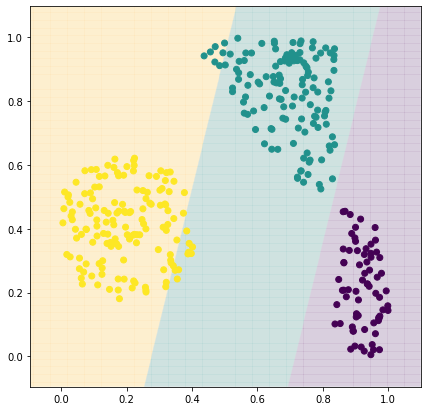

In [153]:
nn_surface(nn, "mse")

In [155]:
nn = nn_learning(X_train, y_train, NLLLoss, 0.005)

0 285.60129721013277
200 264.3879359858337
400 72.58110976957292
600 8.096892861393515
800 2.8497895801554725
1000 1.7217370476641634


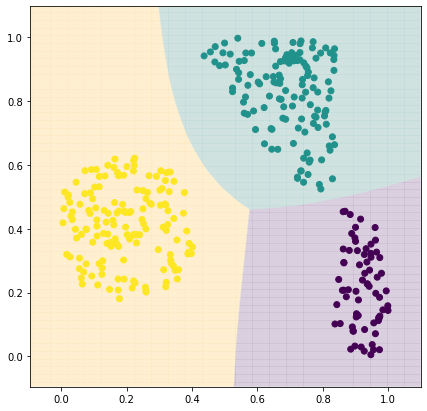

In [156]:
nn_surface(nn, "nll")